Целью данного проекта является анализ результатов A/B-теста на маркетплейсе, направленного на изменение пользовательского интерфейса (тестовая группа) и оценку его влияния на конверсию по сравнению с контрольной группой. Срок проведения тестирования: 16 дней.

Источник данных:

https://www.kaggle.com/datasets/surajatiitb/ecommerce-conversion-ab-test-data/data

In [1]:
# Загрузка необходимых библиотек
import requests
import pandas as pd
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
PUBLIC_KEY = 'https://disk.yandex.ru/d/giWnwgpHGHaYtQ'
API_URL = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'

response = requests.get(API_URL, params={"public_key": PUBLIC_KEY})
download_url = response.json()["href"]



e_commerce = pd.read_csv(download_url)
e_commerce.head()

,TvC,date,traffic_source,device_type,browser_language,login_y_n,region,return_y_n,conversion
0,C,2021-02-14,Referrals,Mweb,Chinese,n,Southwest,y,1
1,C,2021-02-14,Direct,Iphone,English,y,West,y,0
2,C,2021-02-11,Email Marketing,Mweb,English,y,Northeast,y,0
3,C,2021-02-11,Referrals,Iphone,English,y,Southwest,n,0
4,C,2021-02-01,Referrals,Desktop,English,y,Northeast,n,0


# Структура данных:

TvC — группа пользователя: C (контроль) или V1 (вариант / тест)

date — дата посещения

traffic_source — источник трафика

device_type — устройство (mobile / desktop / app)

browser_language — язык браузера

login_y_n — залогинен ли пользователь

region — регион

return_y_n — новый ли пользователь

conversion — бинарная метрика (1 = совершил покупку, 0 = нет)




Проведем EDA и посмотрим на данные в датасете для корректного проведения А/Б тестирования:

In [3]:
e_commerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   TvC               object
 1   date              object
 2   traffic_source    object
 3   device_type       object
 4   browser_language  object
 5   login_y_n         object
 6   region            object
 7   return_y_n        object
 8   conversion        int64 
dtypes: int64(1), object(8)
memory usage: 137.3+ MB


In [4]:
e_commerce.isna().sum()

TvC                 0
date                0
traffic_source      0
device_type         0
browser_language    0
login_y_n           0
region              0
return_y_n          0
conversion          0
dtype: int64

In [5]:
e_commerce.describe()

,conversion
count,2.000000e+06
mean,1.049880e-01
std,3.065380e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


Метрика conversion — бинарная, без пропусков и аномалий.
Среднее значение конверсии около 10.5% - нормальный, реалистичный уровень конверсии для e-commerce.
Распределение смещено в сторону нулей, что делает корректным применение z-test / chi-square для сравнения долей.

In [6]:
# Переименуем значения поля TvC (C - контрольная группа, Т - тестовая)
e_commerce['TvC'] = e_commerce['TvC'].replace('V1', 'T')

# Проверка
e_commerce['TvC'].unique()

array(['C', 'T'], dtype=object)

Проверка групп на соответсвие пропорций выборок (SRM):

In [7]:
e_commerce['TvC'].value_counts(normalize=True)

TvC
C    0.5
T    0.5
Name: proportion, dtype: float64

In [8]:
proportion = e_commerce['TvC'].value_counts(normalize=True) * 100
proportion.round(2)
proportion

TvC
C    50.0
T    50.0
Name: proportion, dtype: float64

Используем более строгую статистическую проверку с помощью критерия Хи-квадрат:

H0: пользователи распределены по группам равномерно

H1: распределение отличается от равномерного

In [9]:
# Фактические размеры групп
fact = e_commerce['TvC'].value_counts().sort_index()

# Ожидаемые размеры групп
expected = [fact.sum() / 2] * 2

chi2_stat, p_value = chisquare(f_obs=fact.values, f_exp=expected)

print(chi2_stat.round(4))
print(p_value.round(4))

0.0
1.0


В ходе проверки SRM(несоответствие пропорции выборок) с помощью хи-квадрата, мы получили p-value равный 1 (что больше 0.5). Значит наши группы поделены равномерно и мы можем проводить А/Б-тест без опасений.


In [10]:
e_commerce.head()

,TvC,date,traffic_source,device_type,browser_language,login_y_n,region,return_y_n,conversion
0,C,2021-02-14,Referrals,Mweb,Chinese,n,Southwest,y,1
1,C,2021-02-14,Direct,Iphone,English,y,West,y,0
2,C,2021-02-11,Email Marketing,Mweb,English,y,Northeast,y,0
3,C,2021-02-11,Referrals,Iphone,English,y,Southwest,n,0
4,C,2021-02-01,Referrals,Desktop,English,y,Northeast,n,0


Посмотрим на CR по группам:

In [11]:
group_stats = e_commerce.groupby('TvC')['conversion'] \
    .agg(['count', 'sum']) \
    .rename(columns={'count': 'users', 'sum': 'CR_sum'})

In [12]:
group_stats

,users,CR_sum
TvC,,
C,1000000,100092
T,1000000,109884


In [13]:
group_stats['CR'] = group_stats['CR_sum'] / group_stats['users']
group_stats

,users,CR_sum,CR
TvC,,,
C,1000000,100092,0.100092
T,1000000,109884,0.109884


Сформулируем гипотезы:

H0: конверсия осталась без изменений

H1: конверсия в тестовой группе статистически значимо отличается от конверсии в контрольной


Для сравнения конверсий будем использовать двусторонний z-test, т.к. у нас бинарная исходная метрика и довольно большая выборка. Согласно центральной предельной теореме при больших размерах выборки, распределение выборочных средних стремиться к нормальному, что является "зеленым светом" для проведения именно z-test.

In [14]:
CR_sum = group_stats['CR_sum'].values
users = group_stats['users'].values

z_stat, p_value = proportions_ztest(
    count = CR_sum,
    nobs = users)

print(z_stat.round(4))
print(p_value.round(4))
    

-22.5877
0.0


Значение p-value экстремально низкое и стремится к 0, что является нормой при таких больших выборках. Поэтому следующим шагом проверю 95% доверительный интервал, чтобы оценить диапазон значений эффекта и понять, является ли он значимым для бизнеса.

In [15]:
ci_low, ci_high = confint_proportions_2indep(
    count1=group_stats.loc['T', 'CR_sum'],
    nobs1=group_stats.loc['T', 'users'],
    count2=group_stats.loc['C', 'CR_sum'],
    nobs2=group_stats.loc['C', 'users'],
    method='wald'
)

print(ci_low.round(5))
print(ci_high.round(5))

0.00894
0.01064


В результате проведения А/Б теста было выявлено статистически значимое увеличение конверсии в тестовой группе. 95% доверительный интервал лежит выше нуля, что указывает на положительный эффект тестового изменения.

Проверим абсолютный и относительный эффекты изменения конверсии:

In [16]:
cr_c = group_stats.loc['C', 'CR']
cr_t = group_stats.loc['T', 'CR']

abs_uplift = cr_t - cr_c
relative_uplift = abs_uplift / cr_c

print(abs_uplift.round(4))
print((relative_uplift * 100).round(1))

0.0098
9.8


В результате проведенного А/Б теста показатель конверсии в тестовой группе выше, чем в контрольной.

Результат стат. значим: p-value << 0.5(стремиться к 0).

95% CI для разницы конверсии составляет [0.00894, 0.01064].

Относительный эффект равен +9.8%

Визуализируем CR и CI для того, чтобы можно было быстро оценить различия и неопределенность оценок:

In [17]:
t_ci_low = cr_c + ci_low
t_ci_high = cr_c + ci_high

In [18]:
df = pd.DataFrame({
    'Groups': ['Control', 'Test'],
    'CR': [cr_c, cr_t],
    'CI_low': [cr_c, t_ci_low],
    'CI_high': [cr_c, t_ci_high]})

df

,Groups,CR,CI_low,CI_high
0,Control,0.100092,0.100092,0.100092
1,Test,0.109884,0.109034,0.110734


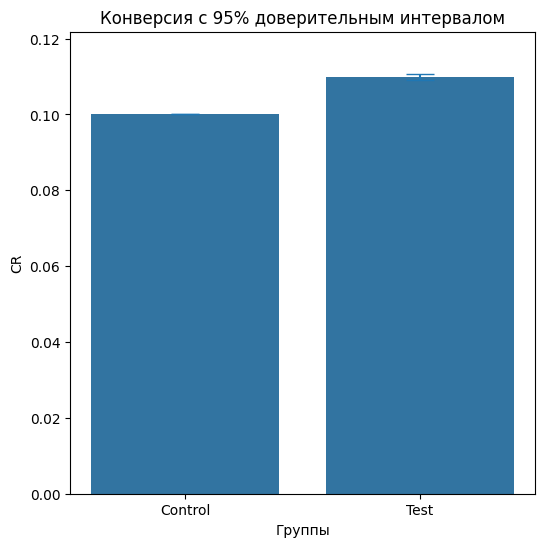

In [19]:
plt.figure(figsize=(6,6))

ax = sns.barplot(data=df, x='Groups', y='CR', errorbar=None)

plt.errorbar(
    x = [0,1],
    y = df['CR'],
    yerr = [
    df['CR'] - df['CI_low'],
        df['CI_high'] - df['CR']
    ],
    fmt='none',
    capsize=10)

plt.ylabel('CR')
plt.xlabel('Группы')
plt.title('Конверсия с 95% доверительным интервалом')
plt.ylim(0, df['CI_high'].max() * 1.1)

plt.show()

Итоги тестирования:

SRM отсутствует - группы поделены ровно пополам, следовательно результаты теста можно надежно интерпретировать.

Благодаря проведенному А/Б тесту мы сильно уверены в том, что наблюдаемый эффект от изменения, а не просто нам повезло. 
Мы ожидаем, что при внедрении тестового изменения мы увеличим конверсию приблизительно на 10% +/- границы доверительного интервала.

Рекомендации: рассмотреть выкатывание тестового изменения на полноценный трафик.
